In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import torch as t
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision as tv
import torchvision.datasets as datasets 
import torchvision.transforms as transforms

In [140]:
transform = transforms.Compose([
    transforms.ToTensor(), 
])

dataset_path = '../../datasets/mnist/handwritten_digits/'

mnist_trainset = datasets.MNIST(root=dataset_path, train=True, download=True, transform=transform)
train_loader = t.utils.data.DataLoader(mnist_trainset, batch_size=32, shuffle=True)

mnist_testset = datasets.MNIST(root=dataset_path, train=False, download=True, transform=transform)
test_loader = t.utils.data.DataLoader(mnist_testset, batch_size=32, shuffle=True)

One batch X:  torch.Size([32, 1, 28, 28])
One batch Y:  torch.Size([32])


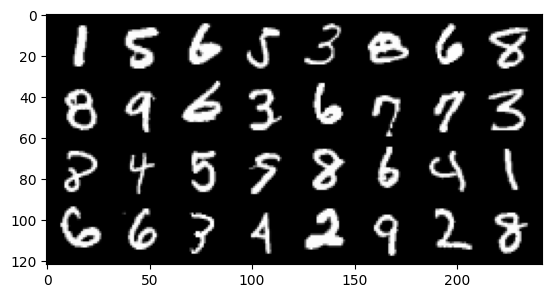

In [55]:
# one batch
one_batch_test = next(iter(train_loader))
one_batch_test_x = one_batch_test[0] # input
one_batch_test_y = one_batch_test[1] # labels

print("One batch X: ", one_batch_test_x.shape)
print("One batch Y: ", one_batch_test_y.shape)

one_batch_test_x_grid = tv.utils.make_grid(one_batch_test_x)
plt.imshow(one_batch_test_x_grid.numpy().transpose((1, 2, 0)))

In [57]:
print("Label: ", one_batch_test_y)

Label:  tensor([1, 5, 6, 5, 3, 8, 6, 8, 8, 9, 6, 3, 6, 7, 7, 3, 8, 4, 5, 9, 8, 6, 4, 1,
        6, 6, 3, 4, 2, 9, 2, 8])


In [230]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        # image size = 28x28
        self.conv1 = nn.Conv2d(1, 2, 3)  
        # image size = 26x26 x 2
        self.pool = nn.MaxPool2d(2, 2)
        # image size = 13x13 x 2
        self.layer1 = nn.Linear(13 * 13 * 2, 20)
        self.layer2 = nn.Linear(20, 10)

    def forward(self, batch_inputs):
        y = self.pool(self.conv1(batch_inputs))
        y = t.flatten(y, 1)
        y = self.layer1(y)
        y = self.layer2(y)
        # y = F.softmax(y, dim=1)
        return y

    def predict(self, single_image_input):
        y = self.forward(single_image_input.unsqueeze(0))
        return t.argmax(y, dim=1)
    
    def fit_batch(self, train_load, test_loader, loss_func, optimizer):
        self.train()
        for i, batch in enumerate(train_load):
            batch_x, batch_y = batch

            y_pred = self.forward(batch_x)
            loss = loss_func(y_pred, batch_y)
            loss.backward()

            optimizer.step()
            optimizer.zero_grad()

            if i % 200 == 0:
                print(f"Batch {i}/{len(train_load)}      training loss: {loss}")

        total_loss = 0
        self.eval()
        with t.no_grad():
            for i, batch in enumerate(test_loader):
                batch_x, batch_y = batch
                y_pred = self.forward(batch_x)
                loss = loss_func(y_pred, batch_y)
                total_loss += loss
        total_loss /= len(test_loader)
        print(f"Validation loss: {total_loss}")
        return total_loss

In [238]:
model = Net()
loss_func = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())

In [239]:
epochs = 10

losses = []
for epoch in range(epochs):
    print(f"Epoch {epoch}/{epochs}")
    loss = model.fit_batch(train_loader, test_loader, loss_func, optimizer)
    losses.append(loss)

Epoch 0/10
Batch 0/1875      training loss: 2.3011837005615234
Batch 200/1875      training loss: 0.4675646722316742
Batch 400/1875      training loss: 0.6033260226249695
Batch 600/1875      training loss: 0.2810880243778229
Batch 800/1875      training loss: 0.1871274709701538
Batch 1000/1875      training loss: 0.2946750819683075
Batch 1200/1875      training loss: 0.27416113018989563
Batch 1400/1875      training loss: 0.10166552662849426
Batch 1600/1875      training loss: 0.19230611622333527
Batch 1800/1875      training loss: 0.1745411902666092
Validation loss: 0.2561889886856079
Epoch 1/10
Batch 0/1875      training loss: 0.32450854778289795
Batch 200/1875      training loss: 0.09633509814739227
Batch 400/1875      training loss: 0.1975540667772293
Batch 600/1875      training loss: 0.09274130314588547
Batch 800/1875      training loss: 0.2580568194389343
Batch 1000/1875      training loss: 0.1252686232328415
Batch 1200/1875      training loss: 0.12213678658008575
Batch 1400/187

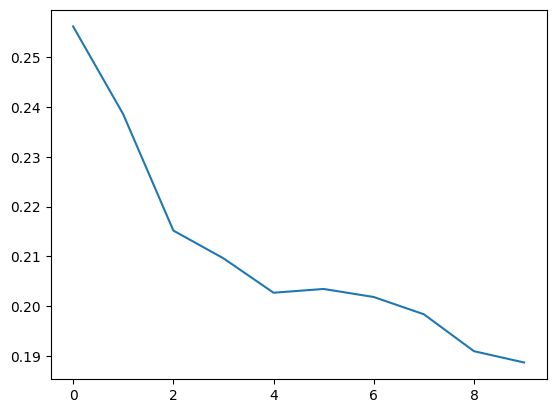

In [240]:
plt.plot(losses)

In [241]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

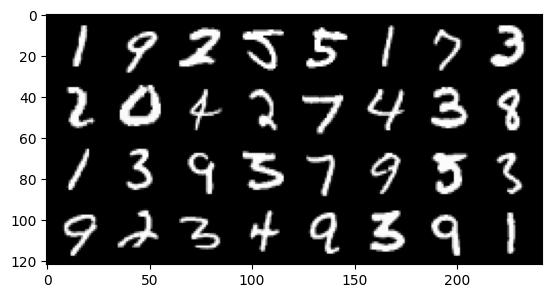

In [242]:
test = next(iter(test_loader))
test_images = tv.utils.make_grid(test[0])
plt.imshow(test_images.numpy().transpose((1, 2, 0)))

In [243]:
test_preds = model.forward(test[0])
test_preds = t.argmax(test_preds, dim=1)
print("Predictions: ", test_preds)
print("True labels: ", test[1])

Predictions:  tensor([1, 9, 2, 8, 5, 1, 7, 3, 2, 0, 4, 2, 7, 4, 3, 8, 1, 3, 9, 3, 7, 9, 5, 3,
        9, 2, 3, 4, 9, 5, 9, 1])
True labels:  tensor([1, 9, 2, 5, 5, 1, 7, 3, 2, 0, 4, 2, 7, 4, 3, 8, 1, 3, 9, 3, 7, 9, 5, 3,
        9, 2, 3, 4, 9, 3, 9, 1])


In [244]:
accuracy_score(test[1], test_preds)

0.9375

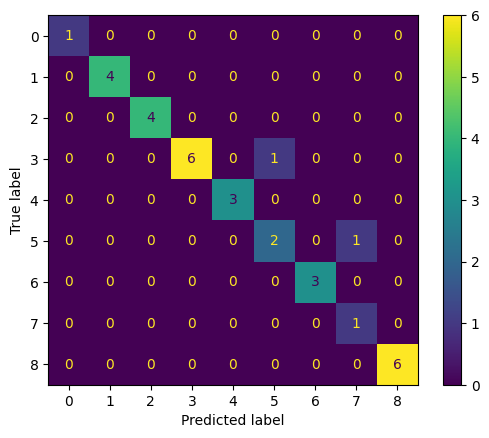

In [245]:
ConfusionMatrixDisplay(confusion_matrix(test[1], test_preds)).plot()

In [248]:
t.onnx.export(model, t.randn(1, 1, 28, 28), "handwritten.onnx")